<a href="https://colab.research.google.com/github/imraunav/pattern-recognition/blob/main/q1_done.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


# NOTE
### The classes given below are non-speech and speech. The following code uses the labels class 0 and class 1 to represent non-speech and speech 

# Importing datasets 

In [ ]:
path = '/drive/My Drive/Semester_1/pattern_recognition_cs669/assignment_1/q1/'
#Getting feature vectors for training
with open(path + "Segment2_MelEnergy.csv", mode = 'r') as file:
    file_data = file.read()
    # for data in file_data.splitlines():
    #     Mel_train_featues.append(float(data))
    Mel_train_features = [float(data) for data in file_data.splitlines()]
# print(MelEnergy_data)

#Getting the ground truths
with open(path + 'Segment2_VAD_GT.csv', mode = 'r') as file:
    file_data = file.read()
    GT_train = [int(x) for x in file_data.splitlines()]
# print(GT)

#Testng features and ground truth data
with open(path + 'Segment3_MelEnergy.csv', mode = 'r') as file:
    file_data = file.read()
    Mel_test_features = [float(data) for data in file_data.splitlines()]
# print(Mel_test)

with open(path + 'Segment3_VAD_GT.csv', mode = 'r') as file:
    file_data = file.read()
    GT_test = [float(data) for data in file_data.splitlines()]
# print(GT_test)

#Getting STEnergy training features
with open(path + 'Segment2_STEnergy.csv', mode = 'r') as file:
    file_data = file.read()
    ST_train_features = [float(item) for item in file_data.splitlines()]
# print(ST_data)

#Getting testing STEnergy features
with open(path + 'Segment3_STEnergy.csv', mode = 'r') as file:
    file_data = file.read()
    ST_test_features = [float(item) for item in file_data.splitlines()]
# print(ST_test)

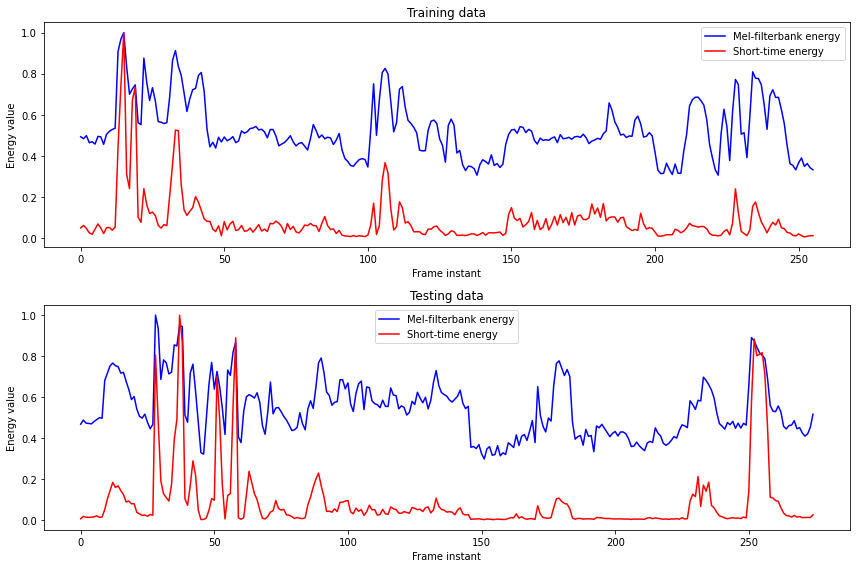

In [ ]:
fig, ax = plt.subplots(2, 1)
ax[0].plot(Mel_train_features, label = 'Mel-filterbank energy', color = 'Blue')
ax[0].plot(ST_train_features, label = 'Short-time energy', color = 'Red')
ax[1].plot(Mel_test_features, label = 'Mel-filterbank energy', color = 'Blue')
ax[1].plot(ST_test_features, label = 'Short-time energy', color = 'Red')

ax[0].legend()
ax[1].legend()
ax[1].set_title('Testing data')
ax[0].set_title('Training data')

ax[0].set_xlabel('Frame instant')
ax[1].set_xlabel('Frame instant')

ax[0].set_ylabel('Energy value')
ax[1].set_ylabel('Energy value')
# fig.show()
fig.tight_layout(rect=(0, 0, 2, 2))
fig.savefig("plot_features.png", dpi = 750, bbox_inches = 'tight')
fig.show()

# Generalising some calculations

In [ ]:
def confusion_mat(pred, actual):
    true_pos, false_pos, true_neg, false_neg = 0, 0, 0, 0
    for i in range(len(pred)):
        if pred[i] == 0 and actual[i] == 0:
            true_neg += 1
        if pred[i] == 0 and actual[i] == 1:
            false_neg += 1
        if pred[i] == 1 and actual[i] == 0:
            false_pos += 1
        if pred[i] == 1 and actual[i] == 1:
            true_pos += 1
    return true_pos, false_pos, true_neg, false_neg

In [ ]:
def tp_fp_rate(pred, actual):
    tp, fp, tn, fn = confusion_mat(pred, actual)
    fpr = fp / (fp + tn)
    tpr = tp / (tp + fn)
    return tpr, fpr

In [ ]:
def likelihood(x, mean, var):
    return (1/((2 * np.pi * var) ** 0.5)) * np.exp(- 0.5 * (x - mean) ** 2 / var)

# Classifer based on MEL-Filterbank energy as features

In [ ]:
#Some constants
class_0_features = [x for i, x in enumerate(Mel_train_features) if GT_train[i] == 0]
class_1_features = [x for i, x in enumerate(Mel_train_features) if GT_train[i] == 1]

mean_0_mel = np.mean(class_0_features)
mean_1_mel = np.mean(class_1_features)

var_0_mel = np.var(class_0_features)
var_1_mel = np.var(class_1_features)

prior_0_mel = len(class_0_features)/len(GT_train)
prior_1_mel = len(class_1_features)/len(GT_train)

Mean of class 0 features = 0.45865463603448275, Variance of class 0 features = 0.005185428144146614
Mean of class 1 features = 0.6100466456738739, Variance of class 1 features = 0.022868307223842404


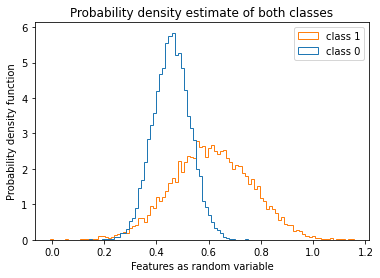

In [ ]:
class_0_dis = np.random.normal(mean_0_mel, var_0_mel ** 0.5, size = 10000)
class_1_dis = np.random.normal(mean_1_mel, var_1_mel ** 0.5, size = 10000)

print(f'Mean of class 0 features = {mean_0_mel}, Variance of class 0 features = {var_0_mel}')
print(f'Mean of class 1 features = {mean_1_mel}, Variance of class 1 features = {var_1_mel}')

_ = plt.hist([class_0_dis, class_1_dis], bins = 100, density = True, label = ['class 0', 'class 1'], histtype = 'step')

plt.ylabel('Probability density function')
plt.xlabel('Features as random variable')
plt.title('Probability density estimate of both classes')
plt.legend()
plt.savefig("distribution_mel.png", dpi = 350)
plt.show()

In [ ]:
#classifier
posteriors_mel = []
for x in Mel_test_features:
    likelihood_0 = likelihood(x, mean_0_mel, var_0_mel)
    likelihood_1 = likelihood(x, mean_1_mel, var_1_mel)
    evidence = likelihood_1 * prior_1_mel + likelihood_0 * prior_0_mel
    posterior_x = likelihood_1 * prior_1_mel / evidence
    posteriors_mel.append(posterior_x)

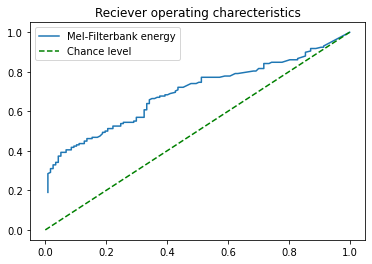

In [ ]:
thresholds = sorted(np.random.uniform(0, 1, size = 1000))
# thresholds = np.linspace(0, 1, 1000)
x_roc_mel = []
y_roc_mel = []
for p_star in thresholds:
    classified = [1 if p > p_star else 0 for p in posteriors_mel]
    tpr, fpr = tp_fp_rate(classified, GT_test)
    x_roc_mel.append(fpr)
    y_roc_mel.append(tpr)
    
plt.plot(x_roc_mel, y_roc_mel, label = 'Mel-Filterbank energy')
plt.plot([0, 1], [0, 1], color = 'green', linestyle = '--', label = 'Chance level')
plt.legend()
plt.title('Reciever operating charecteristics')
plt.savefig('roc_mel', dpi = 350)
plt.show()

# Classifier based on Short-time energy as features

In [ ]:
#Some constants
class_0_features = [x for i, x in enumerate(ST_train_features) if GT_train[i] == 0]
class_1_features = [x for i, x in enumerate(ST_train_features) if GT_train[i] == 1]

mean_0_st = np.mean(class_0_features)
mean_1_st = np.mean(class_1_features)

var_0_st = np.var(class_0_features)
var_1_st = np.var(class_1_features)

prior_0_st = len(class_0_features)/len(GT_train)
prior_1_st = len(class_1_features)/len(GT_train)

Mean of class 0 features = 0.053090674108275865, Variance of class 0 features = 0.0012944035189149682
Mean of class 1 features = 0.12043432332432433, Variance of class 1 features = 0.027681259243278893


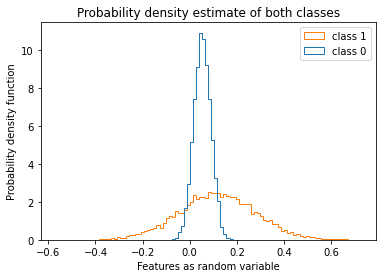

In [ ]:
class_0_dis = np.random.normal(mean_0_st, var_0_st ** 0.5, size = 10000)
class_1_dis = np.random.normal(mean_1_st, var_1_st ** 0.5, size = 10000)

print(f'Mean of class 0 features = {mean_0_st}, Variance of class 0 features = {var_0_st}')
print(f'Mean of class 1 features = {mean_1_st}, Variance of class 1 features = {var_1_st}')

_ = plt.hist([class_0_dis, class_1_dis], bins = 100, density = True, label = ['class 0', 'class 1'], histtype = 'step')

plt.ylabel('Probability density function')
plt.xlabel('Features as random variable')
plt.title('Probability density estimate of both classes')
plt.legend()
plt.savefig('distribution_ste', dpi = 350)
plt.show()

In [ ]:
#classifier
posteriors_st = []
for x in ST_test_features:
    likelihood_0 = likelihood(x, mean_0_st, var_0_st)
    likelihood_1 = likelihood(x, mean_1_st, var_1_st)
    evidence = likelihood_1 * prior_1_st + likelihood_0 * prior_0_st
    posterior_x = likelihood_1 * prior_1_st / evidence
    posteriors_st.append(posterior_x)

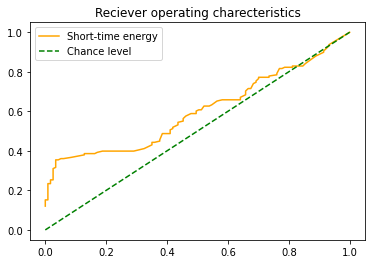

In [ ]:
thresholds = sorted(np.random.uniform(0, 1, size = 1000))
# thresholds = np.linspace(0, 1, 1000)
x_roc_st = []
y_roc_st = []
for p_star in thresholds:
    classified = [1 if p > p_star else 0 for p in posteriors_st]
    tpr, fpr = tp_fp_rate(classified, GT_test)
    x_roc_st.append(fpr)
    y_roc_st.append(tpr)
    
plt.plot(x_roc_st, y_roc_st, label = 'Short-time energy', color = 'orange')
plt.plot([0, 1], [0, 1], color = 'green', linestyle = '--', label = 'Chance level')
plt.legend()
plt.title('Reciever operating charecteristics')
plt.savefig('roc_ste', dpi = 350)
plt.show()

# Conclusion (MEL vs ST)

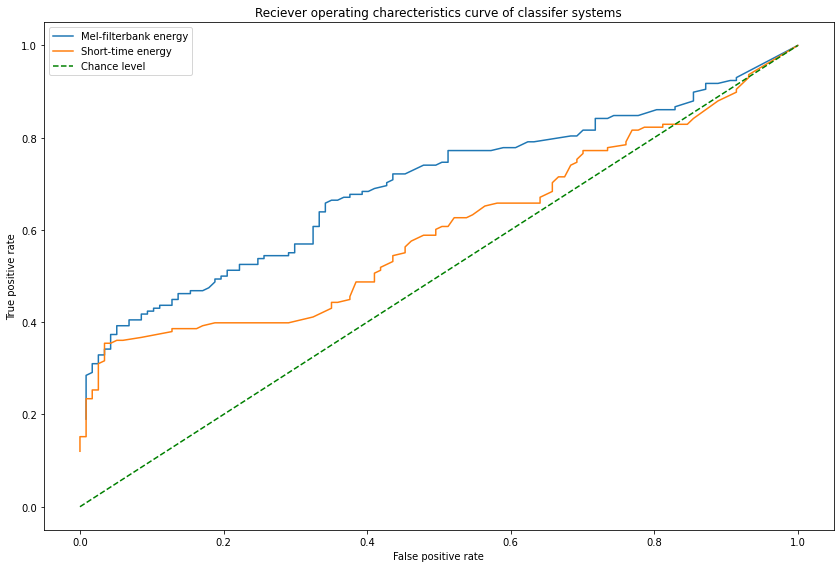

In [ ]:
plt.plot(x_roc_mel, y_roc_mel, label = 'Mel-filterbank energy')
plt.plot(x_roc_st, y_roc_st, label = 'Short-time energy')
plt.plot([0, 1], [0, 1], label = 'Chance level', linestyle = '--', color = 'Green')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()
plt.title('Reciever operating charecteristics curve of classifer systems')
plt.tight_layout(rect = (0, 0, 2, 2))
plt.savefig('conclusion', dpi = 500, bbox_inches = 'tight')
plt.show()

In [ ]:
from google.colab import files
for fig in ("plot_features.png", "distribution_mel.png", 'roc_mel.png', 'distribution_ste.png', 'roc_ste.png', 'conclusion.png'):
  files.download(fig)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>